# Classifying Normal and Tumor tissue using RNA-seq data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Import data

tumor = pd.read_csv("Primary_Tumor_FPKM.csv", index_col = 0)
normal = pd.read_csv("Solid_Tumor_FPKM.csv", index_col = 0)

In [4]:
# Combine Data into one frame
allData = tumor.append(normal)
allData.head()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000078237.5,ENSG00000146083.10,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,ENSG00000231981.3,ENSG00000134108.11,...,ENSG00000272515.1,ENSG00000009694.12,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000123685.7,ENSG00000181518.3
TCGA-B2-4098,17617.224082,128.655041,63040.284079,118686.297308,352310.079395,836.111571,2.397861e+06,853.862318,0.000000,932447.020809,...,5453.016807,9341.966195,7333.378311,0.0,5971.227640,3090.741067,324813.739621,7278.362048,9948.928027,0.0
TCGA-B0-4846,4899.385005,203.941568,51423.009186,89639.459221,242946.306285,651.068007,1.981451e+06,6316.457451,477.169184,660888.127029,...,785.820035,67380.980588,332.135266,0.0,3155.159504,816.564167,228434.290999,961.460297,33593.203044,0.0
TCGA-CZ-5458,2325.711202,193.619889,48988.208941,51454.917845,261341.729255,927.175241,3.754032e+06,7281.798758,453.019192,368022.986060,...,0.000000,36031.571339,315.325580,0.0,0.000000,2325.711202,249180.718680,8945.438666,14972.676691,0.0
TCGA-BP-5006,2703.576494,62.521637,58263.893221,96516.697058,278095.801177,278.008144,4.283618e+06,6224.187129,0.000000,389257.808551,...,0.000000,33664.377125,1018.215208,0.0,1450.898950,2252.980411,203092.682638,4951.824276,92804.855475,0.0
TCGA-B8-A54D,16495.368608,352.120735,110295.716087,66755.475290,414637.252093,301.103242,1.463964e+06,3505.450976,0.000000,421478.525505,...,0.000000,485938.792390,860.185456,0.0,4085.718371,0.000000,357869.642390,3984.083586,33538.883520,0.0


In [5]:
# make y labels for dataset
# note: 0 = Tumor, 1 = Normal
labels = pd.Series(["Primary Tumor", "Normal Tumor"]).repeat([530, 72])
y = pd.Series([0, 1]).repeat([530, 72])
print(labels)
print(y)

0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
0    Primary Tumor
         ...      
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal Tumor
1     Normal

## Normalize data before dimensionality reduction


In [10]:
# normalize data
allData_norm = normalize(allData, axis = 0)
allData_norm.shape

(602, 52677)

In [11]:
allData_normDF = pd.DataFrame(allData_norm)
allData_normDF.head()

,0,1,2,3,4,5,6,7,8,9,...,52667,52668,52669,52670,52671,52672,52673,52674,52675,52676
0,0.083628,0.000878,0.030993,0.055679,0.046999,0.011280,0.025755,0.003630,0.000000,0.066818,...,0.024576,0.006112,0.001649,0.0,0.005919,0.056212,0.045810,0.031052,0.009059,0.0
1,0.023257,0.001391,0.025282,0.042052,0.032410,0.008783,0.021282,0.026857,0.005932,0.047358,...,0.003542,0.044082,0.000075,0.0,0.003128,0.014851,0.032217,0.004102,0.030589,0.0
2,0.011040,0.001321,0.024085,0.024139,0.034864,0.012508,0.040322,0.030961,0.005632,0.026372,...,0.000000,0.023573,0.000071,0.0,0.000000,0.042298,0.035143,0.038164,0.013634,0.0
3,0.012834,0.000427,0.028645,0.045278,0.037099,0.003750,0.046010,0.026464,0.000000,0.027894,...,0.000000,0.022024,0.000229,0.0,0.001438,0.040975,0.028643,0.021126,0.084505,0.0
4,0.078303,0.002402,0.054226,0.031317,0.055313,0.004062,0.015724,0.014905,0.000000,0.030203,...,0.000000,0.317912,0.000193,0.0,0.004050,0.000000,0.050473,0.016997,0.030539,0.0


In [12]:
# Borrowed from Week9 notebook - to help plot clustering functions later on (e.g. TSNE)
def scatterplot_2D(R, title, labels=None):
    """ Helper function to plot data points in 2D
        Requires (N, 2) numpy array shape
    """
    assert(R.shape[1] == 2)
    # class labels are turned into colors
    if labels is None:
        c = 'black'
    else:
        color_scale = np.linspace(0, 1, len(set(labels)))
        c = [plt.cm.Set1(color_scale[i]) for i in labels]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')
    ax.scatter(R[...,0], R[...,1], color=c)
    ax.axis('square')
    ax.set_xlabel('R1')
    ax.set_ylabel('R2')
    fig.suptitle(title)
    plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

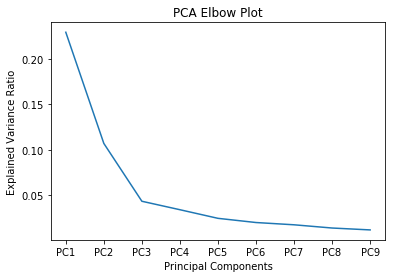

In [36]:
pca = PCA(n_components = 9)
pca.fit(allData_norm)
variance = pca.explained_variance_ratio_
PC = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']

sb.lineplot(PC, variance)
plt.title("PCA Elbow Plot")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.show


In [37]:
# run pca with 4 components to make new data set
pca = PCA(n_components = 4)
allData_pca = pca.fit_transform(allData_norm)
allData_pca.shape


(602, 4)

## Preparing/Splitting data for model training

In [38]:
# finally, define input for classification models
X = allData_pca
# y is defined above

# stratify data to train/test model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

# define cross validation method
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=1000, random_state=42)



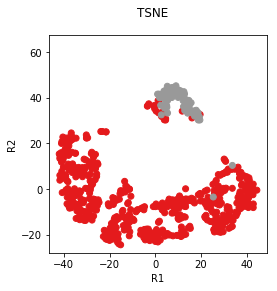

In [39]:
# TSNE 
R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X)
scatterplot_2D(R_TSNE, 'TSNE', y)


## Classification
Finding the best classifier:

1. Logistic Regression
2. K Nearest Neighbors Classifier 
3. Support Vector Machines Classification
4. Random Forest Classifier

### Logistic Regression

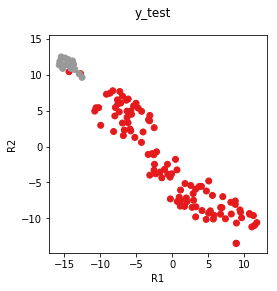

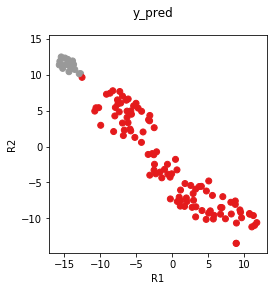

Accuracy: 0.98 (+/- 0.02)


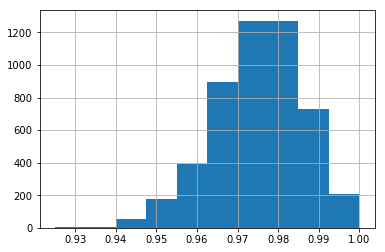

In [40]:
# train model
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# TSNE - visualize accuracy of model
R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_test', y_test)

R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_pred', y_pred)


# cross validate to evaluate model
scores = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')

pd.Series(scores).hist()
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### K Nearest Neighbors Classifier

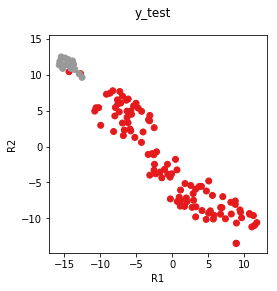

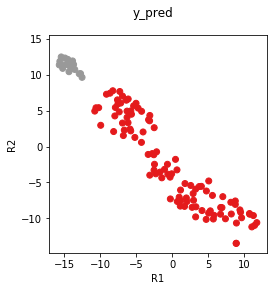

Accuracy: 0.98 (+/- 0.02)


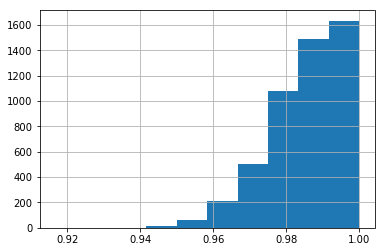

In [41]:
# train model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# TSNE - visualize accuracy of model
R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_test', y_test)

R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_pred', y_pred)


# cross validate to evaluate model
scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')

pd.Series(scores).hist()
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Support Vector Machines Classifier

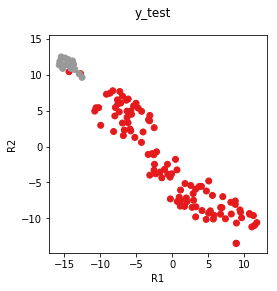

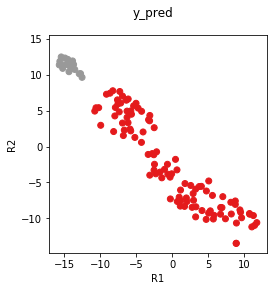

Accuracy: 0.98 (+/- 0.02)


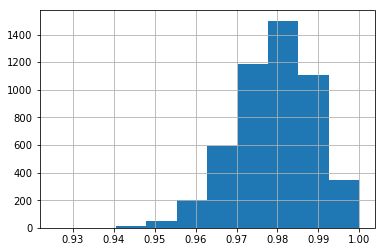

In [42]:
# train model
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# TSNE - visualize accuracy of model
R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_test', y_test)

R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_pred', y_pred)


# cross validate to evaluate model
scores = cross_val_score(svc, X, y, cv=cv, scoring='accuracy')

pd.Series(scores).hist()
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Random Forest Classifier

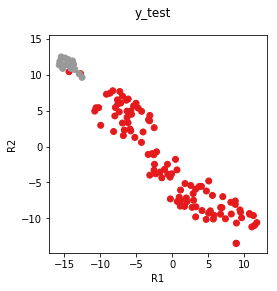

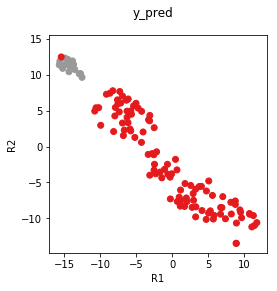

Accuracy: 0.98 (+/- 0.02)


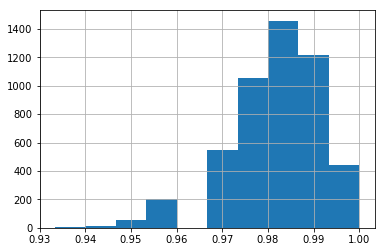

In [43]:
# train model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# TSNE - visualize accuracy of model
R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_test', y_test)

R_TSNE = TSNE(n_components=2, perplexity=20, random_state=42).fit_transform(X_test)
scatterplot_2D(R_TSNE, 'y_pred', y_pred)


# cross validate to evaluate model
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')

pd.Series(scores).hist()
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))